# Morphology predictions vs actual OSI comparisons pipeline
- get predictions of morphology - calculated preferred dir
- regress with functional DSI 
- relate with cell type (eg L2/3 vs L4)

In [1]:
# connectomics imports
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/em-connectomics"
    
# OR if you'd like to override the auto options
# data_root = "./proofread_skeletons/"

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

In [4]:
# if this errors, go to the CAVEsetup notebook
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)

In [5]:
#coreg_df = pd.read_feather('coreg_good_scans_func_resp_dsi.feather')
coreg_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')
good_unit_ids = [4862,2075,5543,3210,3287,3551,6076,8228,5185,2724,6529]
DSIdf = coreg_df[coreg_df.unit_id.isin(good_unit_ids)]

In [6]:
np.vstack(coreg_df.pt_position.values).shape

(8944, 3)

In [7]:
highOSIdf = coreg_df[(coreg_df.OSI >= 0.5) & (coreg_df.Act_Pref_Or >= 20)]

In [8]:
highOSIdf.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [9]:
highOSIdf = highOSIdf.sort_values(by=['OSI'],ascending=False)

In [10]:
lowOSIdf = coreg_df[(coreg_df.OSI <= 0.1) & (coreg_df.Act_Pref_Or >= 20)]

In [11]:
lowOSIdf.shape

(73, 35)

In [12]:
lowOSIdf = lowOSIdf.sort_values(by=['OSI'])

864691135162193197
[0.58805106]
864691136388935440
[2.55217663]
864691135730101177
[2.54941335]
864691135334504681
[0.59144864]
864691134988665466
[-2.90384918]
864691135181980674
[-2.14648904]
864691135948961482
[0.19801983]
864691135865591173
864691135568891782
[2.92792669]
864691135490240615
[1.37330808]


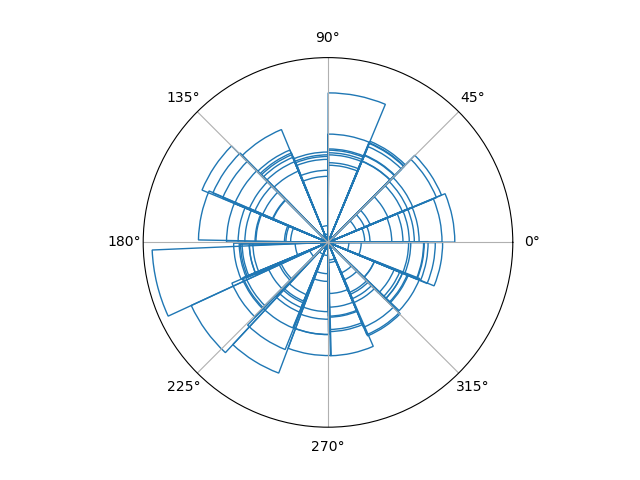

In [21]:
# iterate over N = 20-50 neurons to calculate major Axis orientations
# for high DSI/OSI and low DSI/OSI
# For Basal and Apical:  synaptic density,cable length qty (for now - use skeleton vertices),avg syn size
from meshparty import meshwork
from angularUtils import *

Ncells = 10
theta_highOSI = np.zeros((Ncells,1))
theta_highOSI[:] = np.nan
nuc_id_list_highOSI = np.zeros((Ncells,1))
mesh_files_highOSI = []
osi_theta_highOSI = np.zeros((Ncells,1))
osi_theta_highOSI[:] = np.nan
angularHet_highOSI = np.zeros((Ncells,1))
nuc_type_highOSI = []
fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(Ncells):
    neuron_id = highOSIdf.iloc[i].pt_root_id
    print(neuron_id)
    
    neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
    
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue
        
    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    if not (os.path.exists(os.path.join(data_root,mesh_filename))):
        continue
        
    osi_theta_highOSI[i] = highOSIdf.iloc[i].pref_or * (np.pi/180)
    nuc_type_highOSI.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    #mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    mesh_files_highOSI.append(mesh_filename)
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    
    # get basal dendrite mesh
    basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    # get apical dendrite mesh
    #apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    #apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    #apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df

    #syn_pos_apical = np.vstack(syndf_apical['ctr_pt_position'].values)
    #syn_pos_apical_norm = np.column_stack((syn_pos_apical[:,0]*4, syn_pos_apical[:,1]*4, syn_pos_apical[:,2]*40))
    #skeleton_vertices = syn_pos_apical_norm
    
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    syn_size_basal = np.squeeze(np.vstack(syndf_basal['size'].values))
    skeleton_vertices = syn_pos_basal_norm
    
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    if (len(skeleton_vertices) == 0):
        continue
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights = syn_size_basal, bins=16, density=True, offset=0, gaps=True)
    theta_highOSI[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    print(theta_highOSI[i])
    angularHet_highOSI[i] = np.max(n)/np.mean(n)



In [22]:
syn_size_basal.shape

(2549,)

In [23]:
x.shape

(2549,)

In [24]:
skel_pos_radial

array([[ 3.00480937e+04,  3.05584903e-01],
       [ 2.41666865e+04,  9.60205959e-01],
       [ 5.33604882e+04,  1.46821867e+00],
       ...,
       [ 4.39742470e+04, -7.26189100e-01],
       [ 3.80572276e+04,  2.93195281e+00],
       [ 4.70365278e+04,  2.25935001e+00]])

In [25]:
theta_lowOSI = np.zeros((Ncells,1))
theta_lowOSI[:] = np.nan

mesh_files_lowOSI = []
osi_theta_lowOSI = np.zeros((Ncells,1))
osi_theta_lowOSI[:] = np.nan
angularHet_lowOSI = np.zeros((Ncells,1))
nuc_type_lowOSI = []

for i in range(Ncells):
    neuron_id = lowOSIdf.iloc[i].pt_root_id
    print(neuron_id)
    neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
    
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue

    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    if not (os.path.exists(os.path.join(data_root,mesh_filename))):
        continue
            
    osi_theta_lowOSI[i] = lowOSIdf.iloc[i].pref_or * (np.pi/180)
    nuc_type_lowOSI.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    mesh_files_lowOSI.append(mesh_filename)
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    
    # get basal dendrite mesh
    basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    # get apical dendrite mesh
    #apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    #apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    #apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df


    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    skeleton_vertices = syn_pos_basal_norm
    
    syn_size_basal = np.squeeze(np.vstack(syndf_basal['size'].values))
    
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    if (len(skeleton_vertices) == 0):
        continue
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights = syn_size_basal,bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins, weights=syn_size_basal)
    theta_lowOSI[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    print(theta_lowOSI[i])
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0])
    #theta[i] = (bin_edges[hist.argmax()] + bin_edges[hist.argmax() + 1])/2
    angularHet_lowOSI[i] = np.max(n)/np.mean(n)


864691135501819997
[-2.94530712]
864691135585162108
[0.58770192]
864691136004983754
[-2.13438831]
864691135293126156
[2.93539544]
864691135780799312
[-1.35235805]
864691136690277486
[2.94327005]
864691135524401138
[2.55167114]
864691135991483841
[-1.76758521]
864691136923043556
[0.19489287]
864691136008399020
[0.9799152]


[-2.49318624]
-2.493186242173525


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[-0.59034329]
-0.5903432890784854


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[-2.93577208]
-2.9357720843491695


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[2.55001544]
2.5500154382731153


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[-2.29465077]
-2.2946507735947286


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


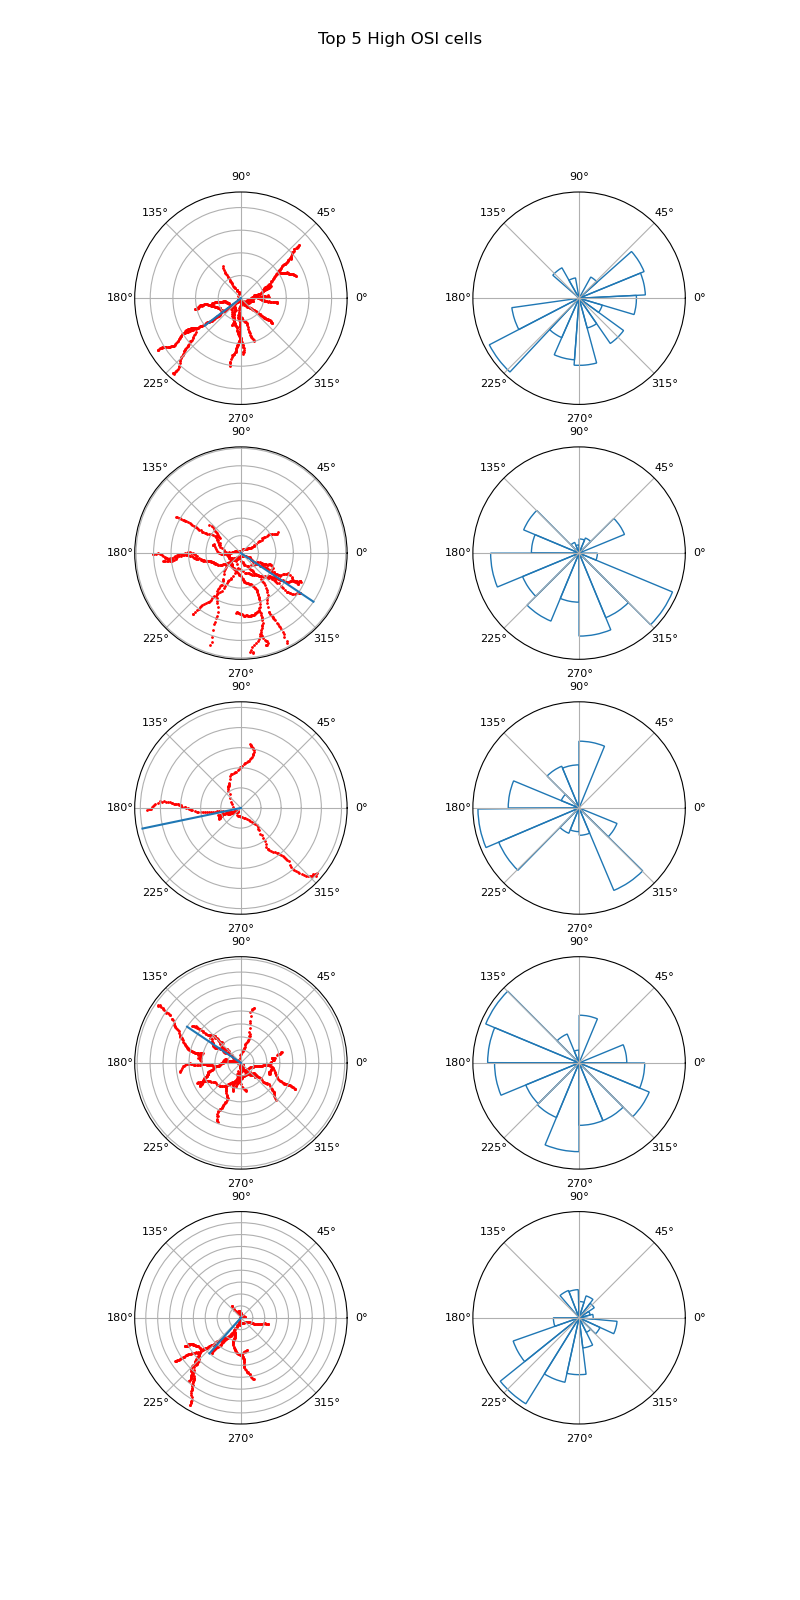

In [42]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
Ncells = 5
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Top 5 High OSI cells')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_highOSI[i]))
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16, density=True, offset=0, gaps=True)
    theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    print(theta[i])
    print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=1,color='r')
    axs[i,0].plot([0,theta[i]],[0,1e5])
    axs[i,0].set_yticklabels([])
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    

[2.94400797]
2.9440079669042998


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[-1.89952248]
-1.8995224836357183


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[2.55141348]
2.551413480230982


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[0.13642041]
0.13642040688148338


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[1.35514154]
1.3551415363843562


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


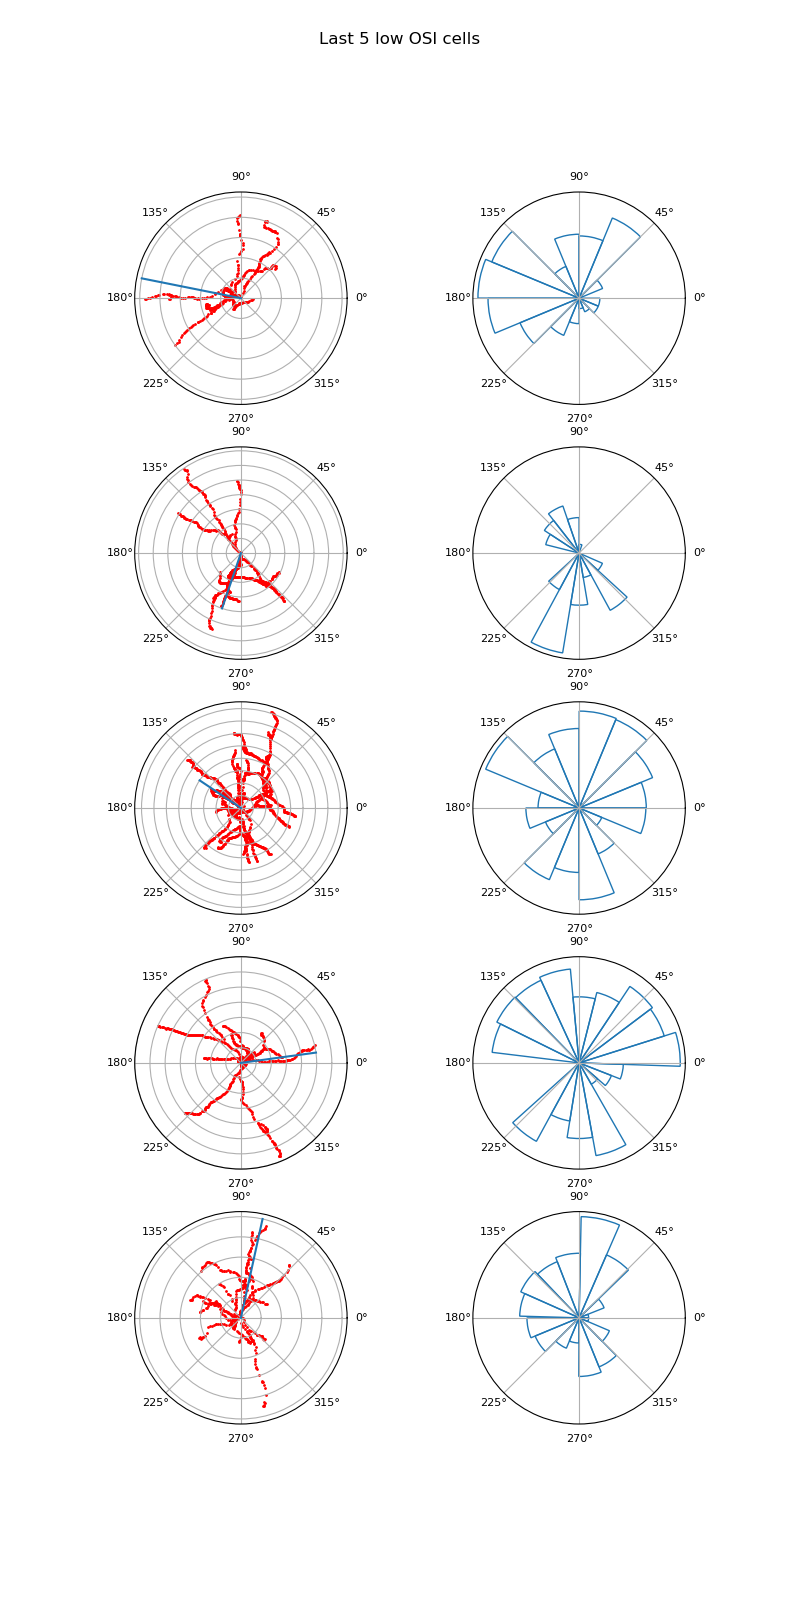

In [43]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
Ncells = 5
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Last 5 low OSI cells')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_lowOSI[i]))
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.apical_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16, density=True, offset=0, gaps=True)
    theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    print(theta[i])
    print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=1,color='r')
    axs[i,0].plot([0,theta[i]],[0,1e5])
    axs[i,0].set_yticklabels([])
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    

In [15]:
np.abs(angularHet_highOSI[~np.isnan(angularHet_highOSI)]).mean()

2.4088048351492195

In [16]:
np.abs(angularHet_lowOSI[~np.isnan(angularHet_lowOSI)]).mean()

2.3694845326031087

In [17]:
nanmask = ~np.isnan(theta_lowOSI)

In [18]:
from astropy.stats import circcorrcoef
theta_osi = (osi_theta_lowOSI+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(theta_osi[nanmask]), np.squeeze(theta_lowOSI[nanmask]))

0.2778015207515481

In [19]:
nanmask = ~np.isnan(theta_highOSI)

In [20]:
from astropy.stats import circcorrcoef
theta_osi = (osi_theta_highOSI+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(theta_osi[nanmask]), np.squeeze(theta_highOSI[nanmask]))

-0.08415824750891555

In [141]:
# fitting alpha - visualize wrt strahler number - does your goodness of fit for an alpha vary in space? 
# Can also plot as a function of strahler number


In [124]:
# Do apical and basal dendrites have differential morphologies because of a spread in inputs? 


In [150]:
angularRatio_apical

0.5147194635650768

In [152]:
np.squeeze(np.array(np.where(apical_in_range_mask))).shape

(1285,)

In [153]:
np.array(apical_dendrite_skel).shape

(2434,)

In [216]:
# Question - how to account for area factor while looking at area scaling? 
# normalize by area factor and plot? 



In [18]:
# Other morphology questions:
# get 0th level axis and get +/- 45 degree slices 
# - Sum over lengths of segments in a given +/- 45deg area along the axis of highest variation 
# - length over branching pts and length/syn density for these areas
